In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path): # Load JSON Data
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print("JSON decode error — file is empty or malformed.")
                return {}
    else:
        return {}  # Return empty dict if file doesn't exist


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

def phase_key_to_short(phase_key):
    """
    Convert 'VO2 (space group 14)' to 'VO2_14'
    """
    if " (space group " in phase_key and phase_key.endswith(")"):
        name, sg = phase_key.split(" (space group ")
        sg = sg.rstrip(")")
        return f"{name} ({sg})"
    return phase_key

# variable init 
json_file_path = "Data/prompt3/interpretations_llm_v2_llama1.json"
json_file = load_json(json_file_path)

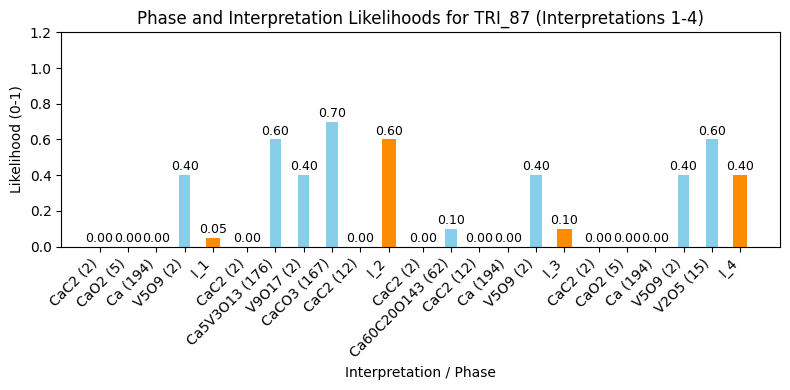

hello


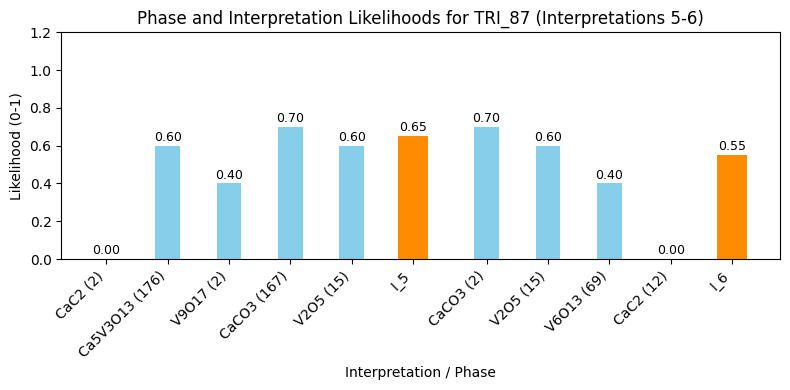

hello


In [21]:
# variable init 
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
json_file = load_json(json_file_path)
run = "TRI_87"
interpretations = [j for j in json_file[run].keys() if j.startswith("I_")]
n_per_plot = 4
bar_gap = 0.2
#print(interpretations)
for chunk_start in range(0, len(interpretations), n_per_plot):
    bar_labels = []
    bar_values = []
    bar_colors = []
    bar_types = []  # Track if it's a phase or interpretation bar
    bar_positions = []
    position = 0
    chunk = interpretations[chunk_start:chunk_start + n_per_plot]
    for interpretation in chunk:
        llama_phase_list = json_file[run][interpretation]["LLM_phases_likelihood_llama"]
        for phase in llama_phase_list:
            phase_name = phase_key_to_short(phase)
            bar_labels.append(f"{phase_name}")
            bar_values.append(llama_phase_list[phase])
            bar_colors.append("skyblue")
            bar_types.append("phase")
            bar_positions.append(position)
            position += 1
        bar_labels.append(interpretation)
        bar_values.append(json_file[run][interpretation]["LLM_interpretation_likelihood_llama"])
        #bar_values = [i*100 for i in bar_values]
        bar_colors.append("darkorange")
        bar_types.append("interp")
        bar_positions.append(position)
        position += 1 + bar_gap

    plt.figure(figsize=(8, 4))
    # Draw phase bars (thinner)
    phase_indices = [i for i, t in enumerate(bar_types) if t == "phase"]
    plt.bar(
        [bar_positions[i] for i in phase_indices],
        [bar_values[i] for i in phase_indices],
        color=[bar_colors[i] for i in phase_indices],
        width=0.4,
        label="Phase"
    )
    # Draw interpretation bars (wider)
    interp_indices = [i for i, t in enumerate(bar_types) if t == "interp"]
    plt.bar(
        [bar_positions[i] for i in interp_indices],
        [bar_values[i] for i in interp_indices],
        hatch = '',
        color=[bar_colors[i] for i in interp_indices],
        width=0.5,
        label="Interpretation"
    )

    plt.ylabel('Likelihood (0-1)')
    plt.xlabel('Interpretation / Phase')
    plt.title(f'Phase and Interpretation Likelihoods for {run} (Interpretations {chunk_start+1}-{chunk_start+len(chunk)})')
    plt.ylim(0, 1.2)
    for j, val in enumerate(bar_values):
        plt.text(bar_positions[j], val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    plt.xticks(bar_positions, bar_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print("hello")

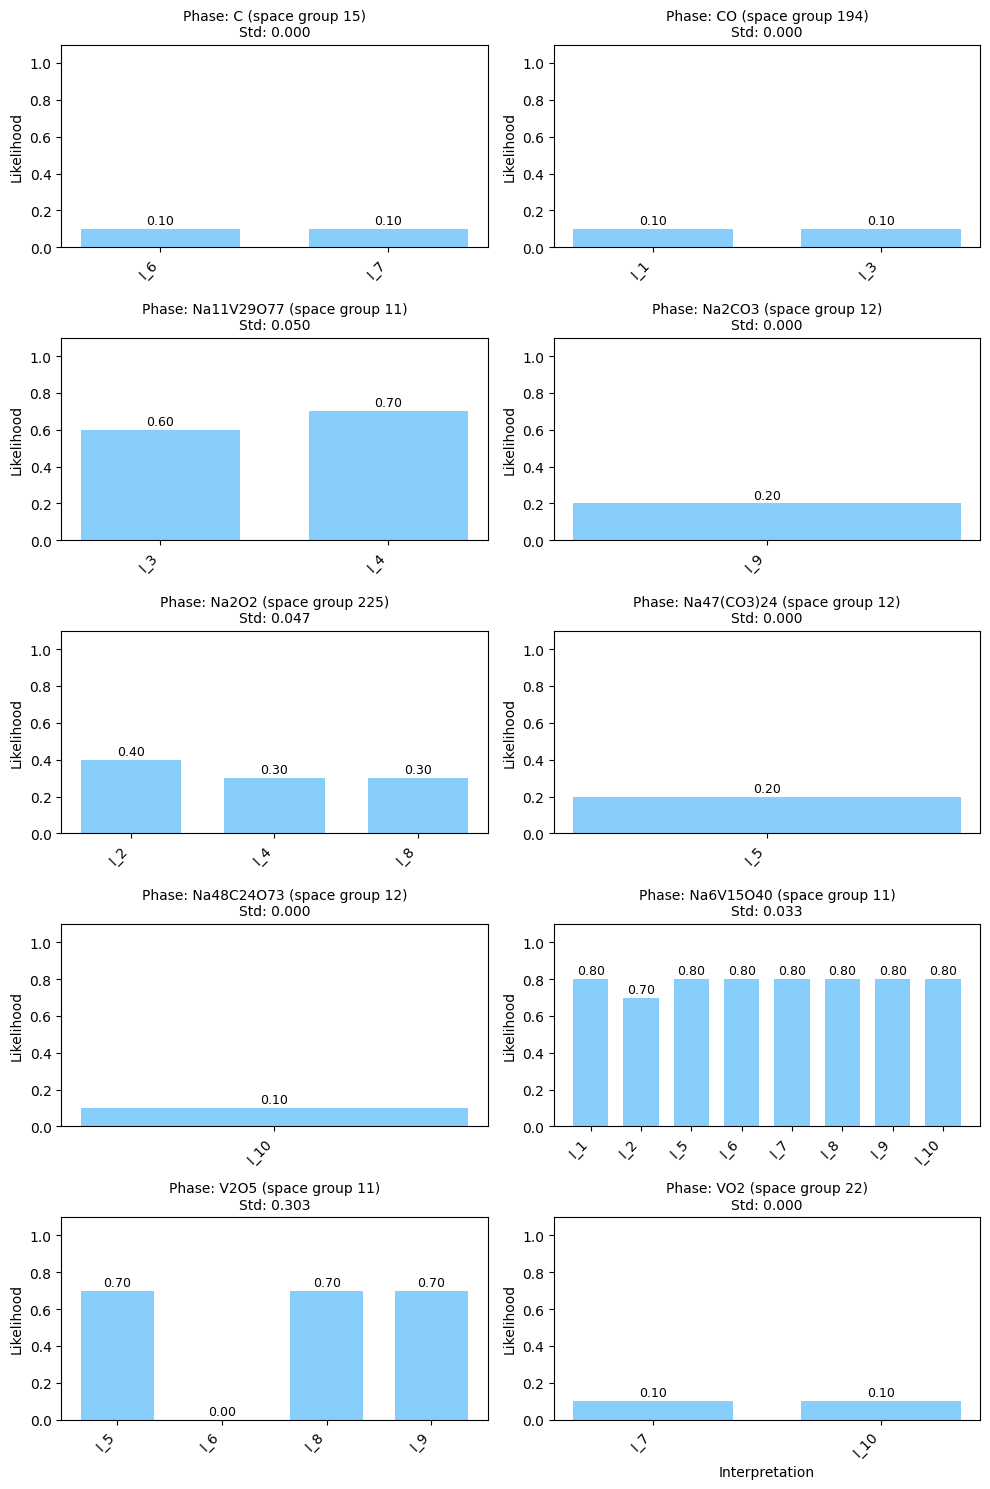

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

run = "TRI_181"

# ---- Pick a range of interpretations to process ----
start_idx = 0   # inclusive
end_idx = 10     # exclusive (change as needed)
# ---------------------------------------------------

all_interpretations = [k for k in json_file[run] if k.startswith("I_")]
interpretations = all_interpretations[start_idx:end_idx]

# 1. Collect all unique phase names for the selected interpretations
all_phases = set()
for interpretation in interpretations:
    phase_likelihoods = json_file[run][interpretation].get("LLM_phases_likelihood_llama", {})
    for phase in phase_likelihoods:
        all_phases.add(phase)
all_phases = sorted(all_phases)

# 2. For each phase, collect only interpretations where phase is present
phase_likelihood_matrix = []
phase_interp_labels = []
for phase in all_phases:
    likelihoods = []
    interp_labels = []
    for interp in interpretations:
        phase_likelihoods = json_file[run][interp].get("LLM_phases_likelihood_llama", {})
        value = None
        # Try both long and short keys
        if phase in phase_likelihoods:
            value = phase_likelihoods[phase]
        else:
            for k, v in phase_likelihoods.items():
                if phase_key_to_short(k) == phase:
                    value = v
                    break
        if value is not None:
            likelihoods.append(value)
            interp_labels.append(interp)
    phase_likelihood_matrix.append(likelihoods)
    phase_interp_labels.append(interp_labels)

# 3. Plot: one subplot per phase, x-axis = only interpretations where phase is present
n_phases = len(all_phases)
ncols = 2
nrows = int(np.ceil(n_phases / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3*nrows), sharex=False)
axes = axes.flatten()

if n_phases == 1:
    axes = [axes]

for i, phase in enumerate(all_phases):
    ax = axes[i]
    y = phase_likelihood_matrix[i]
    x_labels = phase_interp_labels[i]
    x = np.arange(len(x_labels))
    std = np.std(y) if len(y) > 1 else 0  # Avoid std of single value
    ax.bar(x, y, color='lightskyblue', width=.7)
    ax.set_ylabel('Likelihood')
    ax.set_title(f'Phase: {phase}\nStd: {std:.3f}', fontsize = 10)
    ax.set_ylim(0, 1.1)
    for j, val in enumerate(y):
        ax.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

axes[-1].set_xlabel('Interpretation')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

interp = []
runs = []
chatgpt_vals = []
llama_vals = []
diff = []
n = 5

def n_farthest_from_zero(values, n): # Returns a list of indices for the largest values from a list
    # Create a list of (index, abs(value)) pairs
    indexed_abs = [(i, abs(val)) for i, val in enumerate(values)]

    # Sort by absolute value in descending order and take the top n
    top_n = sorted(indexed_abs, key=lambda x: x[1], reverse=True)[:n]

    # Extract the original indices
    return [i for i, _ in top_n]
def n_closest_to_zero(values, n): # Returns a list of indices for the largest values from a list
    # Create a list of (index, abs(value)) pairs
    indexed_abs = [(i, abs(val)) for i, val in enumerate(values)]

    # Sort by absolute value in descending order and take the top n
    m = len(values)-n
    top_n = sorted(indexed_abs, key=lambda x: x[1], reverse=True)[m:]

    # Extract the original indices
    return [i for i, _ in top_n]

for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                runs.append(run)
                interp.append(interpret)
                chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
                llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
                chatgpt_vals.append(chatgpt_val)
                llama_vals.append(llama_val)
                diff.append(chatgpt_val - llama_val)
indices = n_farthest_from_zero(diff,n)

interp1 = []
runs1 = []
chatgpt_vals1 = []
llama_vals1 = []
diff1 = []

for i in indices: 
    interp1.append(interp[i])
    runs1.append(runs[i])
    chatgpt_vals1.append(chatgpt_vals[i])
    llama_vals1.append(llama_vals[i])
    diff1.append(diff[i])

# Combine the lists into a DataFrame
df = pd.DataFrame({
    "Run": runs1,
    "interpretation": interp1,
    "chatgpt_vals": chatgpt_vals1,
    "llama_vals": llama_vals1,
    "diff": diff1
})

# Display the table
display(df)

,Run,interpretation,chatgpt_vals,llama_vals,diff
0,TRI_181,I_21,0.10,0.90,-0.80
1,TRI_112,I_6,0.10,0.90,-0.80
2,TRI_104,I_8,0.50,0.05,0.45
3,TRI_182,I_1,0.50,0.95,-0.45
4,TRI_104,I_7,0.45,0.05,0.40


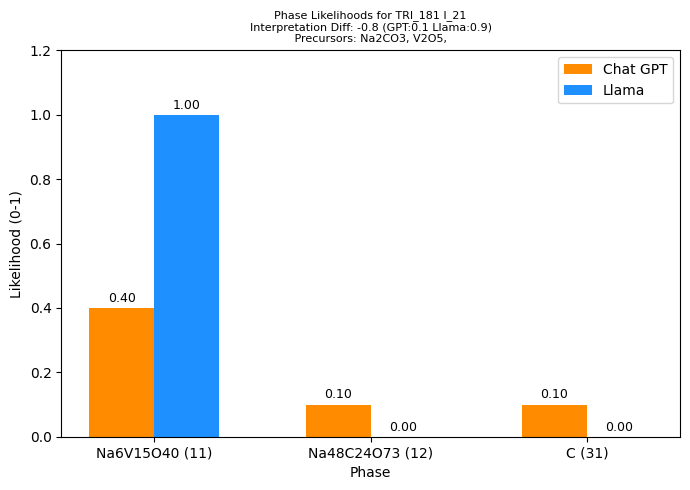

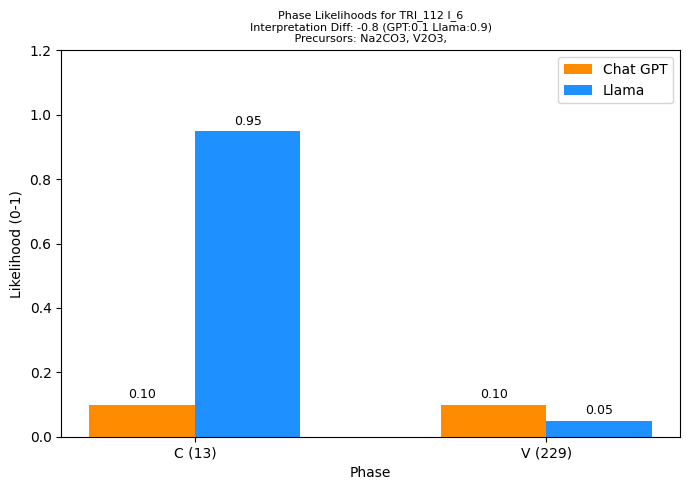

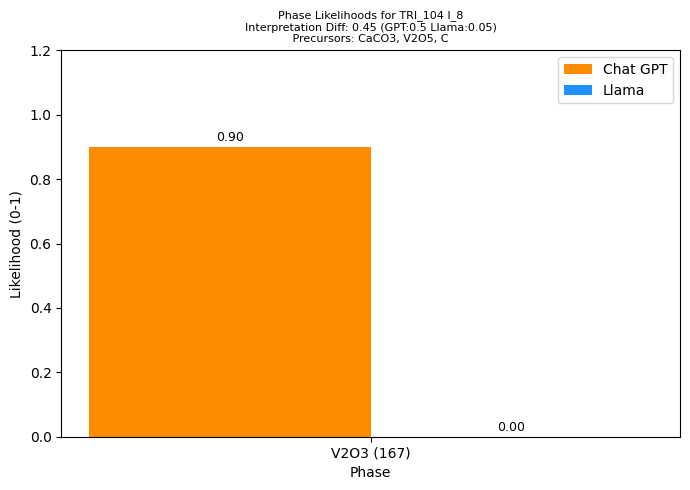

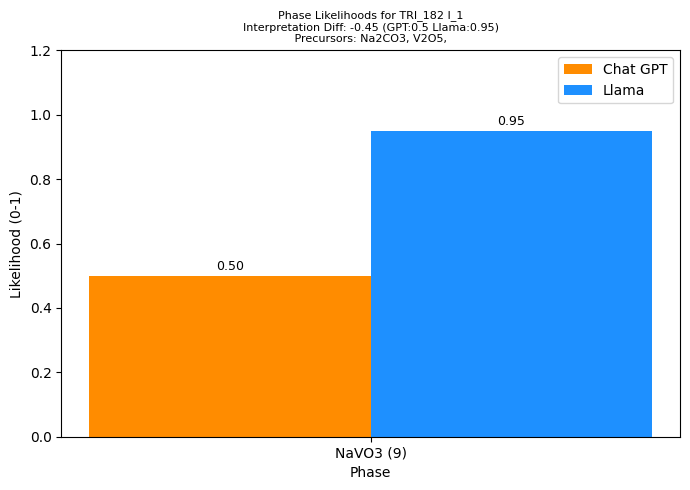

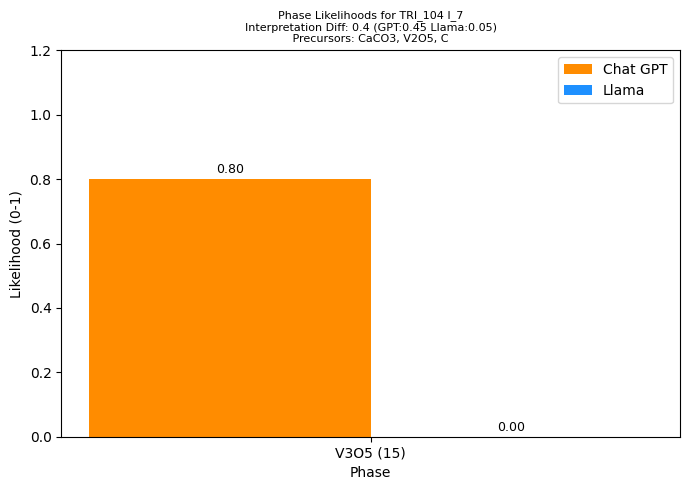

In [ ]:
for i in range(len(interp1)):
    run = runs1[i]
    interpret = interp1[i]
    llama_interpret = llama_vals1[i]
    gpt_interpret = chatgpt_vals1[i]
    diff = round(diff1[i],2)
    run_interpret = json_file[run][interpret]
    gpt_phase_likelihood = run_interpret["LLM_phases_likelihood"]
    llama_phase_likelihood = run_interpret["LLM_phases_likelihood_llama"]
    labels = list(llama_phase_likelihood.keys())
    gpt_likelihoods = list(gpt_phase_likelihood.values())
    llama_likelihoods = list(llama_phase_likelihood.values())
    synth = json_file[run]["Synth_Conditions"]
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'

    x = np.arange(len(labels))
    width = 0.3

    plt.figure(figsize=(7,5))

    plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "darkorange")
    plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "dodgerblue")

    plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
    plt.ylabel('Likelihood (0-1)')
    plt.xlabel('Phase')
    labels = [phase_key_to_short(label) for label in labels]
    plt.xticks(x, labels, rotation=0, ha='center')
    plt.ylim(0, 1.2)
    
    for j, val in enumerate(gpt_likelihoods):
        plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    for j, val in enumerate(llama_likelihoods):
        plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    plt.legend()
    plt.tight_layout()
    plt.show


In [ ]:
print("P2\u2081/c (SG 15) is a known polymorph of V\u2083O\u2085. Its formation is plausible under reducing conditions.")

P2₁/c (SG 15) is a known polymorph of V₃O₅. Its formation is plausible under reducing conditions.


In [ ]:
import numpy as np

def weighted_agreement_score(set1, set2, p=4):
    set1 = np.array(set1)
    set2 = np.array(set2)
    disagreement = np.abs(set1 - set2) ** p
    mean_disagreement = np.mean(disagreement)
    score = 1 - mean_disagreement ** (1/p)
    return score
llama_interpretation_scores = []
gpt_interpretation_scores = []
for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                llama_interpretation_scores.append(json_file[run][interpret]["LLM_interpretation_likelihood_llama"])
                gpt_interpretation_scores.append(json_file[run][interpret]["LLM_interpretation_likelihood"])
agreement = weighted_agreement_score(llama_interpretation_scores,gpt_interpretation_scores,p=8)
agreement = round(agreement,3)

print(f"Llama-ChatGPT Weighted Interpretation Agreement Score: {agreement}")

Llama-ChatGPT Weighted Interpretation Agreement Score: 0.505


In [ ]:
json_file_path1 = "Data/prompt1/interpretations_llm_v1_llama1.json"
json_file_path2 = "Data/prompt1/interpretations_llm_v1_llama2.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
list_agreements = []
agreement_score = []
for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        llama_scores = []
        gpt_scores = []
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                llama_scores.append(json_file1[run][interpret]["LLM_interpretation_likelihood_llama"])
                gpt_scores.append(json_file1[run][interpret]["LLM_interpretation_likelihood"])
    if llama_scores and gpt_scores: 
        run_interpret_agreement = round(weighted_agreement_score(llama_scores,gpt_scores,p=4),3)
        run_interpret_num = len(json_file[run].keys())-1
        agreement_score.append(run_interpret_agreement)
        list_agreements.append(f"{run} ({run_interpret_num} Interpretations): {run_interpret_agreement}")
ranked_agreement = zip(agreement_score,list_agreements)
ranked_agreement = sorted(ranked_agreement)
print("Weighted Agreement Scores by Sample:")
for i in ranked_agreement:
    print(i[1])

Weighted Agreement Scores by Sample:
TRI_112 (10 Interpretations): 0.537
TRI_181 (28 Interpretations): 0.608
TRI_182 (2 Interpretations): 0.618
TRI_104 (8 Interpretations): 0.682
TRI_31 (9 Interpretations): 0.74
TRI_39 (4 Interpretations): 0.769
TRI_63 (3 Interpretations): 0.769
TRI_106 (4 Interpretations): 0.781
TRI_126 (4 Interpretations): 0.806
TRI_172 (9 Interpretations): 0.815
TRI_84 (4 Interpretations): 0.822
TRI_30 (5 Interpretations): 0.86
TRI_197 (4 Interpretations): 0.889
TRI_28 (2 Interpretations): 0.916


I_1: ChatGPT: 0.25 - The interpretation includes a phase (Li14V43O114) that is not well-documented or expected under the given conditions, and LiV3O8 is present in a very minor fraction. The overall composition does not align well with the target LiV3O4, reducing plausibility.
I_1: llama: 0.1 - This interpretation includes an unlikely phase (Li₁₄V₄₃O₁₁₄) and excludes the expected LiV₃O₈, making it highly implausible.
I_2: ChatGPT: 0.3 - The interpretation suggests a single phase, LiV3O8, which is less likely to be the dominant product under the synthesis conditions aimed at LiV3O4. The absence of other phases or unreacted precursors reduces the credibility of this interpretation.
I_2: llama: 0.6 - This interpretation is plausible because LiV₃O₈ can form under similar conditions, but it does not match the target composition. The absence of LiV₃O₄ suggests incomplete reaction or preferential formation of LiV₃O₈.
I_3: ChatGPT: 0.15 - This interpretation suggests a single phase, Li14V43O11

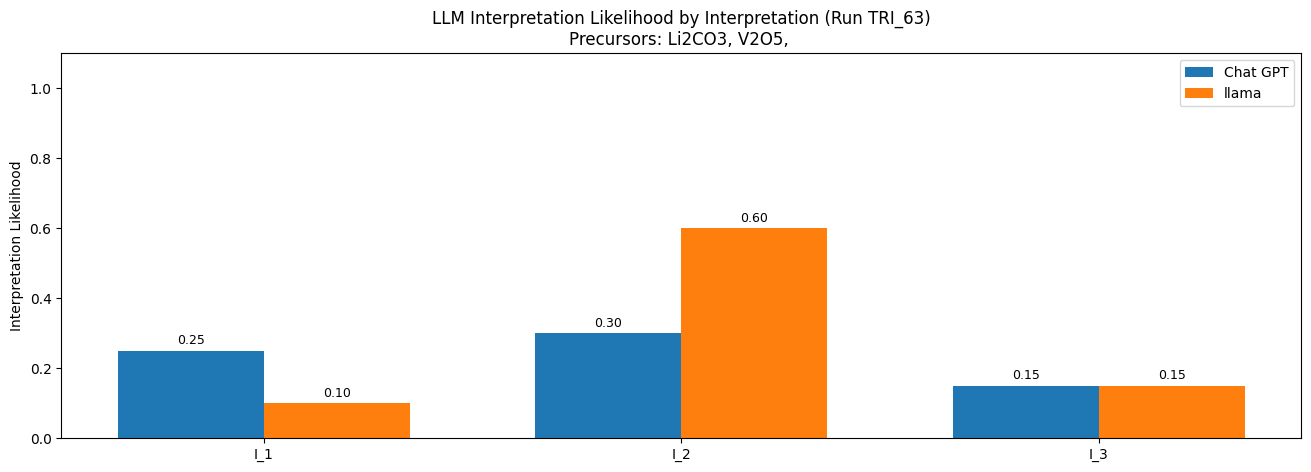

In [ ]:
# for run in json_file:
#     if "Synth_Conditions" in json_file[run]:
run = "TRI_63"
Interpretation = []
ChatGpt_1 = []
llama_1 = []
for interpret in json_file[run]:
    if interpret not in ["Synth_Conditions"]:
        chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
        chatgpt_exp = json_file[run][interpret].get("LLM_interpretation_explanation")
        llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama_exp = json_file[run][interpret].get("LLM_interpretation_explanation_llama")
        #print out the scores and explanations for each interpretation
        print(f"{interpret}: ChatGPT: {chatgpt_val} - {chatgpt_exp}")
        print(f"{interpret}: llama: {llama_val} - {llama_exp}") 
        

        if chatgpt_val is not None and llama_val is not None:
            try:
                ChatGpt_1.append(float(chatgpt_val))
                llama_1.append(float(llama_val))
                Interpretation.append(interpret)
            except ValueError:
                print(f"Non-numeric value in run {run}, interpretation {interpret}: {chatgpt_val}, {llama_val}")
synth = json_file[run]["Synth_Conditions"]
input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'


x1 = np.arange(len(Interpretation))
width = 0.35

plt.figure(figsize=(16,5))
plt.bar(x1 - width/2, ChatGpt_1, width, label='Chat GPT')
plt.bar(x1 + width/2, llama_1, width, label='llama')
plt.ylabel('Interpretation Likelihood')
plt.title(f'LLM Interpretation Likelihood by Interpretation (Run {run})\nPrecursors: {input_phases}')
plt.xticks(x1,Interpretation, rotation=0, ha='center')
for j, val in enumerate(ChatGpt_1):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama_1):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout
plt.show()

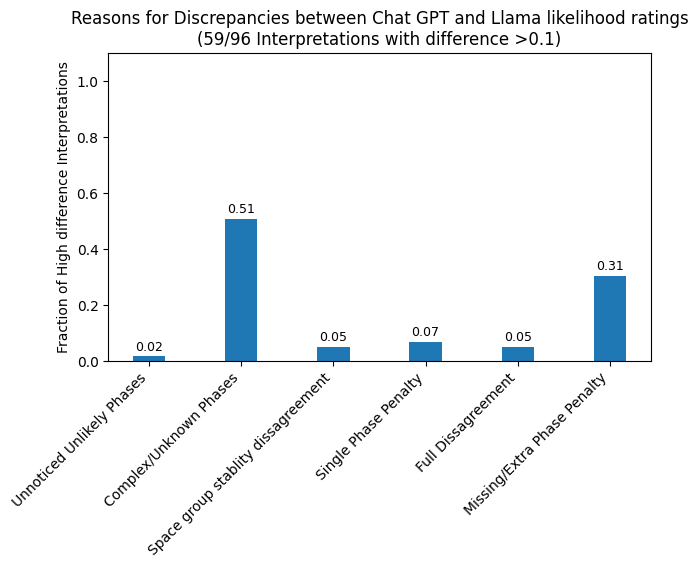

In [ ]:
explain = ["Unnoticed Unlikely Phases","Complex/Unknown Phases","Space group stablity dissagreement","Single Phase Penalty","Full Dissagreement","Missing/Extra Phase Penalty"]
number = [1,30,3,4,3,18]
total = 0
for i in number:
    total += i 
number = [i/total for i in number]
x1 = np.arange(len(explain))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x1, number, width)
plt.ylabel('Fraction of High difference Interpretations')
plt.title(f'Reasons for Discrepancies between Chat GPT and Llama likelihood ratings\n({total}/96 Interpretations with difference >0.1)')
plt.xticks(x1,explain, rotation=45, ha='right',fontsize = 10)
for j, val in enumerate(number):
    plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)

plt.ylim(0,1.1)
plt.tight_layout
plt.show()

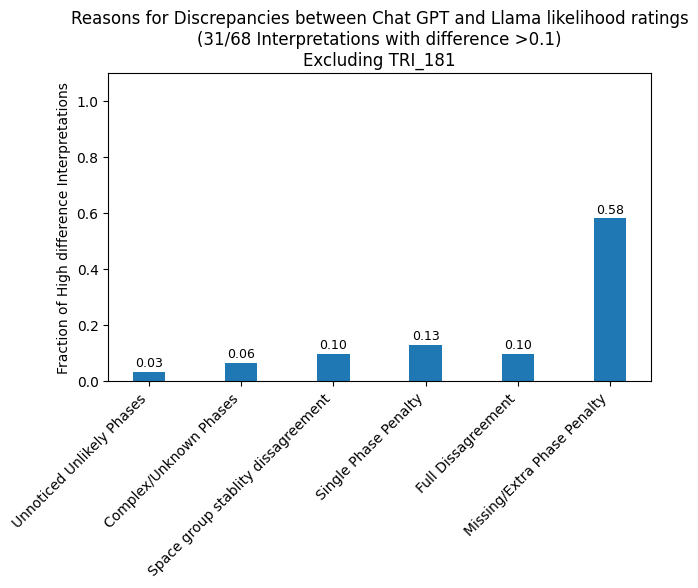

In [ ]:
explain = ["Unnoticed Unlikely Phases","Complex/Unknown Phases","Space group stablity dissagreement","Single Phase Penalty","Full Dissagreement","Missing/Extra Phase Penalty"]
number = [1,2,3,4,3,18]
total = 0
for i in number:
    total += i 
number = [i/total for i in number]
x1 = np.arange(len(explain))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x1, number, width)
plt.ylabel('Fraction of High difference Interpretations')
plt.title(f'Reasons for Discrepancies between Chat GPT and Llama likelihood ratings\n({total}/68 Interpretations with difference >0.1)\nExcluding TRI_181')
plt.xticks(x1,explain, rotation=45, ha='right',fontsize = 10)
for j, val in enumerate(number):
    plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)

plt.ylim(0,1.1)
plt.tight_layout
plt.show()

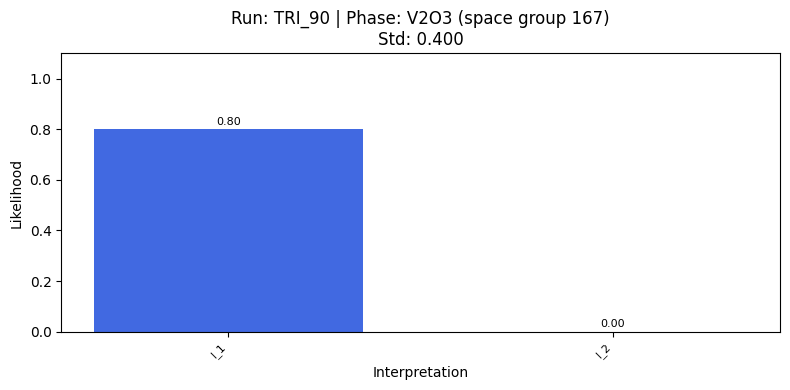

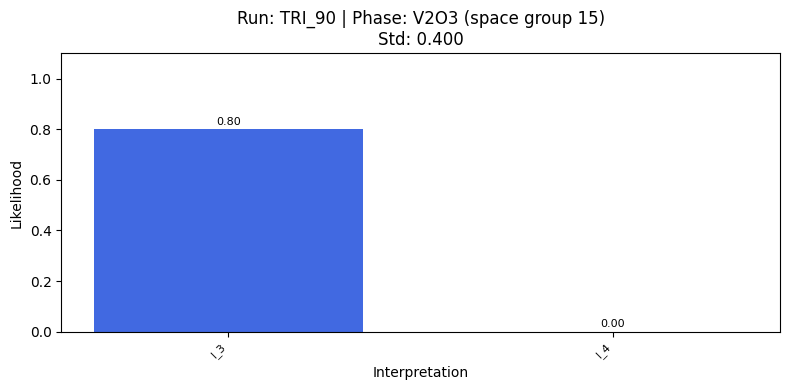

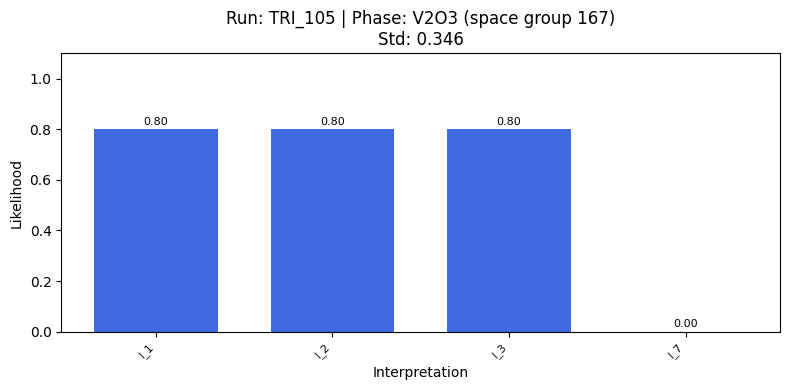

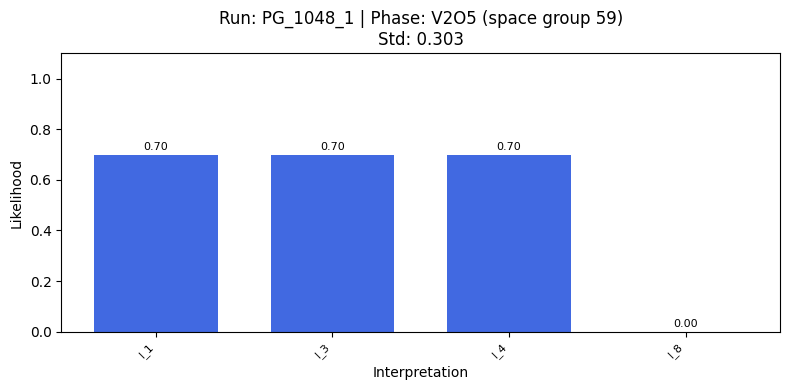

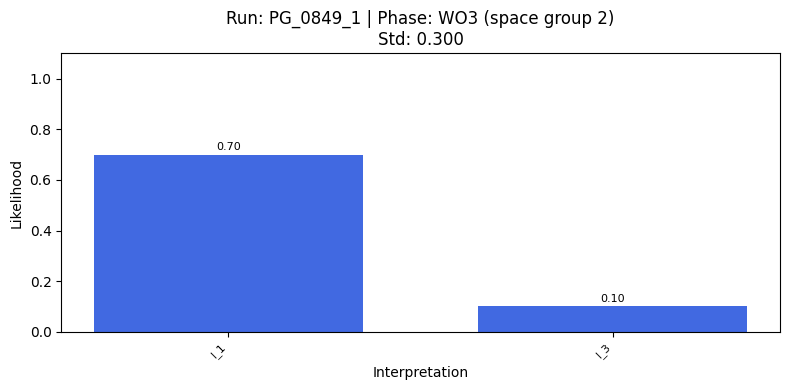

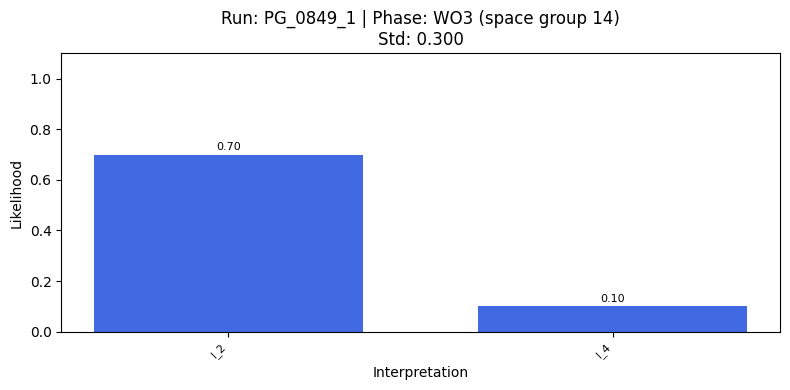

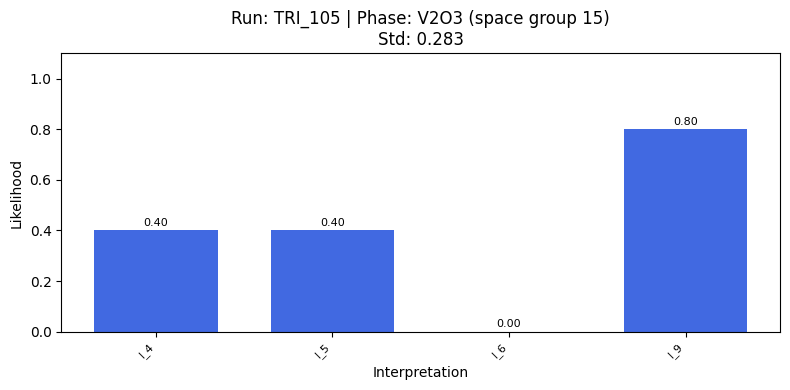

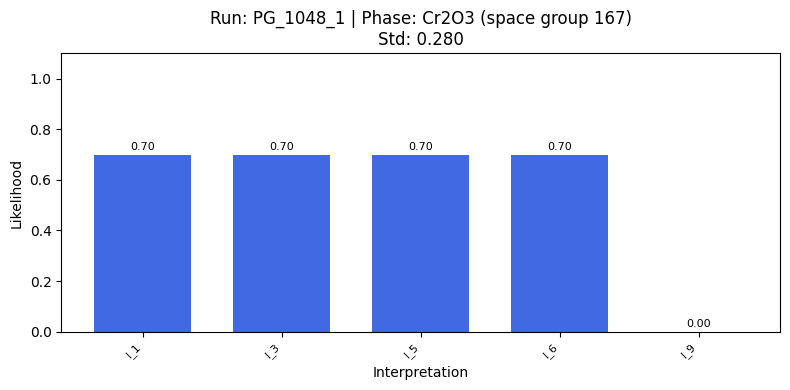

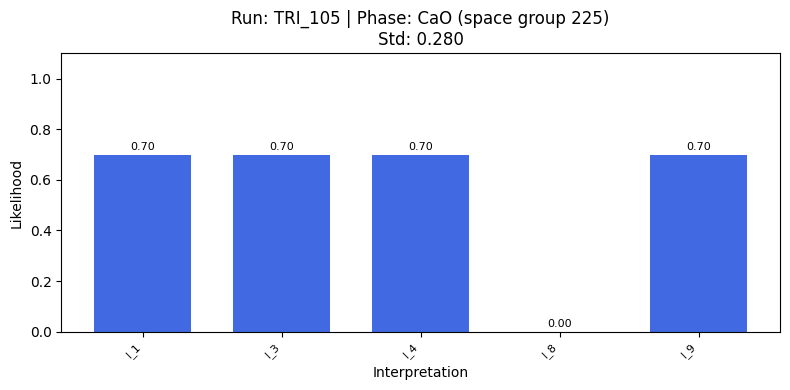

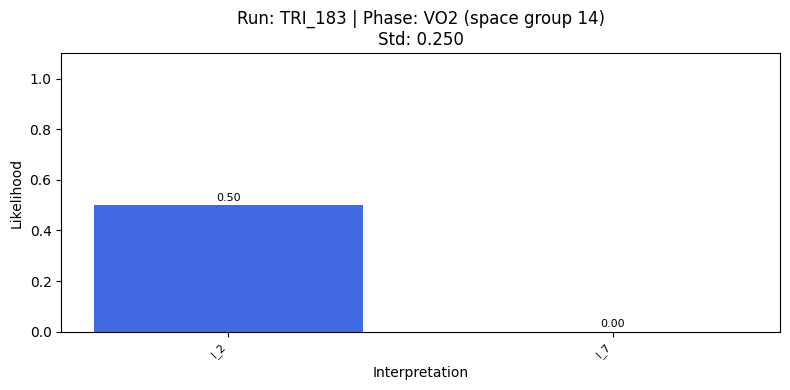

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
json_file_path = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file = load_json(json_file_path)
global_phase_std = []
global_likelihood_dict = {}
for run in json_file:
    if "Synth_Conditions" not in json_file[run]:
        continue

    # 1. Collect all phases and their likelihoods for this run
    phase_likelihoods_dict = {}  # {phase: [(interpretation, likelihood), ...]}
    for interp in json_file[run]:
        if interp.startswith("I_"):
            phase_likelihoods = json_file[run][interp].get("LLM_phases_likelihood_llama", {})
            for phase, likelihood in phase_likelihoods.items():
                if phase not in phase_likelihoods_dict:
                    phase_likelihoods_dict[phase] = []
                phase_likelihoods_dict[phase].append((interp, likelihood))

    # 2. Compute std for each phase (within this run)
    phase_std = []
    for phase, values in phase_likelihoods_dict.items():
        likelihoods = [v[1] for v in values]
        if len(likelihoods) > 1:
            std = np.std(likelihoods)
            phase_std.append((phase, std, run))
    global_phase_std.extend(phase_std)
    global_likelihood_dict[run] = phase_likelihoods_dict
    

# 3. Select top 10 phases by std for all runs
top_phases = sorted(global_phase_std, key=lambda x: x[1], reverse=True)[:10]

# 4. Plot a bar graph for each selected phase
for phase, std, run in top_phases:
    values = global_likelihood_dict[run][phase]
    x_labels = [interp for interp, _ in values]
    y = [likelihood for _, likelihood in values]
    x = np.arange(len(x_labels))

    plt.figure(figsize=(max(8, len(x_labels)//2), 4))
    plt.bar(x, y, color='royalblue', width=0.7)
    plt.ylabel('Likelihood')
    plt.xlabel('Interpretation')
    plt.title(f'Run: {run} | Phase: {phase}\nStd: {std:.3f}', fontsize=12)
    plt.ylim(0, 1.1)
    plt.xticks(x, x_labels, rotation=45, ha='right', fontsize=8)
    for j, val in enumerate(y):
        plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8, rotation=0, clip_on=True)
    plt.tight_layout()
    plt.show()

In [ ]:
json_file_path1 = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file_path2 = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
list_agreements = []
agreement_score = []
for run in json_file1: 
    if "Synth_Conditions" in json_file1[run]:
        llama_scores = []
        gpt_scores = []
        for interpret in json_file1[run]:
            if interpret != "Synth_Conditions":
                llama_scores.append(json_file1[run][interpret]["LLM_interpretation_likelihood"])
                gpt_scores.append(json_file2[run][interpret]["LLM_interpretation_likelihood_llama"])
    if llama_scores and gpt_scores: 
        run_interpret_agreement = round(weighted_agreement_score(llama_scores,gpt_scores,p=4),3)
        run_interpret_num = len(json_file1[run].keys())-1
        agreement_score.append(run_interpret_agreement)
        list_agreements.append(f"{run} ({run_interpret_num} Interpretations): {run_interpret_agreement}")
ranked_agreement = zip(agreement_score,list_agreements)
ranked_agreement = sorted(ranked_agreement)
print("Weighted Agreement Scores by Sample:")
for i in ranked_agreement:
    print(i[1])

Weighted Agreement Scores by Sample:
TRI_106 (4 Interpretations): 0.452
TRI_41 (2 Interpretations): 0.481
TRI_84 (4 Interpretations): 0.595
PG_0849_1 (7 Interpretations): 0.69
TRI_90 (4 Interpretations): 0.703
TRI_105 (9 Interpretations): 0.719
TRI_183 (9 Interpretations): 0.789
ARR_39 (2 Interpretations): 0.79
PG_1048_1 (9 Interpretations): 0.79
TRI_114 (5 Interpretations): 0.809
ARR_46 (3 Interpretations): 0.846
TRI_81 (3 Interpretations): 0.861
TRI_87 (6 Interpretations): 0.861
TRI_80 (5 Interpretations): 0.862
TRI_62 (9 Interpretations): 0.875


I_1: llama1: 0.7 - The presence of LiV₃O₈ is plausible, and Li₄CO₅ could form as a side product. However, the overall composition balance and phase set seem reasonable.
I_1: llama2: 0.7 - The presence of LiV₃O₈ is plausible, but Li₄CO₅'s stability is questionable due to potential decomposition of carbonates at 400 °C.
I_2: llama1: 0.92 - This interpretation is highly plausible with LiV₃O₈ being the dominant and expected phase. The composition balance score supports this scenario.
I_2: llama2: 0.92 - This interpretation is highly plausible as LiV₃O₈ is a known and stable phase under solid-state synthesis conditions.
I_3: llama1: 0.6 - The interpretation includes a less common phase (Li₁₄V₄₃O₁₁₄) and Li₄CO₅. While plausible, it is less straightforward than I_2.
I_3: llama2: 0.72 - Similar to I_1, the presence of Li₁₄V₄₃O₁₁₄ and Li₄CO₅ raises questions about carbonate stability, but the vanadium-rich phase is plausible.


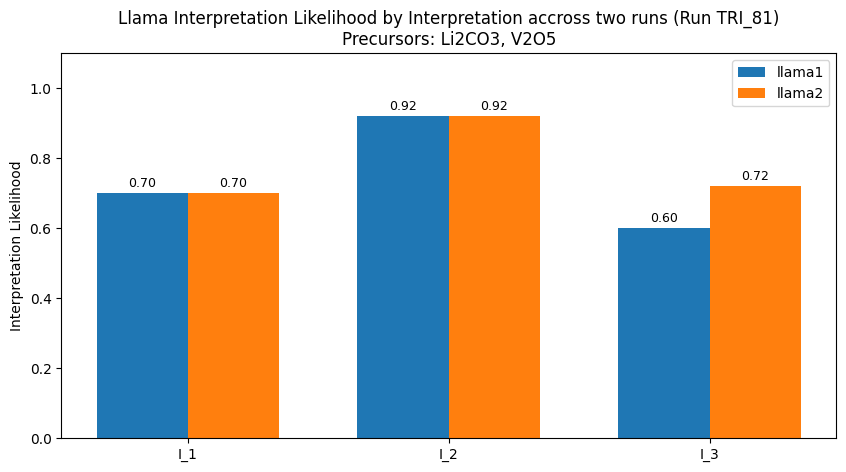

In [26]:
# for run in json_file:
#     if "Synth_Conditions" in json_file[run]:
json_file_path1 = "../Data/prompt3/interpretations_llm_v1_llama1.json"
json_file_path2 = "../Data/prompt3/interpretations_llm_v1_llama2.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
run = "TRI_81"
Interpretation = []
llama1 = []
llama2 = []
for interpret in json_file[run]:
    if interpret not in ["Synth_Conditions"]:
        llama1_val = json_file1[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama1_exp = json_file1[run][interpret].get("LLM_interpretation_explanation_llama")
        llama2_val = json_file2[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama2_exp = json_file2[run][interpret].get("LLM_interpretation_explanation_llama")
        #print out the scores and explanations for each interpretation
        print(f"{interpret}: llama1: {llama1_val} - {llama1_exp}")
        print(f"{interpret}: llama2: {llama2_val} - {llama2_exp}") 
        

        if llama1_val is not None and llama2_val is not None:
            try:
                llama1.append(float(llama1_val))
                llama2.append(float(llama2_val))
                Interpretation.append(interpret)
            except ValueError:
                print(f"Non-numeric value in run {run}, interpretation {interpret}: {llama1_val}, {llama2_val}")
synth = json_file1[run]["Synth_Conditions"]
if "Precursor 3" in synth:
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'
else:
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}'


x1 = np.arange(len(Interpretation))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x1 - width/2, llama1, width, label='llama1')
plt.bar(x1 + width/2, llama2, width, label='llama2')
plt.ylabel('Interpretation Likelihood')
plt.title(f'Llama Interpretation Likelihood by Interpretation accross two runs (Run {run})\nPrecursors: {input_phases}')
plt.xticks(x1,Interpretation, rotation=0, ha='center')
for j, val in enumerate(llama1):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama2):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout
plt.show()

V3O5 (13)
Chat GPT: "Less common polymorph, possibly metastable."
Llama: "This interpretation consists of a single phase with a less common space group. It is unlikely to be the sole product."

Chat GPT Interpretation: "A single-phase interpretation is unlikely given the synthesis conditions and precursors. The composition balance score is low, indicating a mismatch with the target composition."
Llama Interpretation: "This interpretation is highly unlikely due to the absence of other expected phases and a low composition balance score of 0.593."


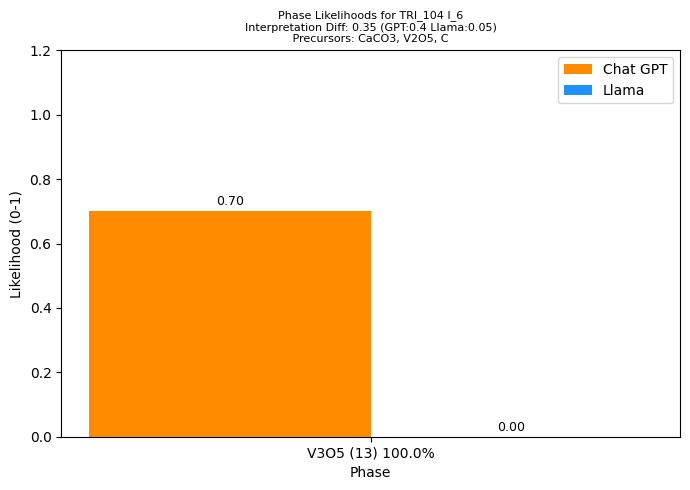

In [27]:
run = "TRI_104"
interpret = "I_6"
json_file_path1 = "../Data/prompt1/interpretations_llm_v1_llama1.json"
json_file_path2 = "../Data/prompt1/interpretations_llm_v1_llama1.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
llama_interpret = json_file1[run][interpret]["LLM_interpretation_likelihood_llama"]
gpt_interpret = json_file2[run][interpret]["LLM_interpretation_likelihood"]
diff = round(gpt_interpret - llama_interpret,2)
labels = []
run_interpret1 = json_file1[run][interpret]
run_interpret2 = json_file2[run][interpret]
gpt_phase_likelihood = run_interpret1["LLM_phases_likelihood"]
llama_phase_likelihood = run_interpret2["LLM_phases_likelihood_llama"]
labels_only = list(llama_phase_likelihood.keys())
for i in range(len(labels_only)):
    wf = run_interpret1["weight_fraction"]
    labels.append(f"{phase_key_to_short(labels_only[i])} {round(wf[i],2)}%")

gpt_likelihoods = list(gpt_phase_likelihood.values())
llama_likelihoods = list(llama_phase_likelihood.values())
synth = json_file1[run]["Synth_Conditions"]
input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(7,5))

plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "darkorange")
plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "dodgerblue")

plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
plt.ylabel('Likelihood (0-1)')
plt.xlabel('Phase')
labels = [phase_key_to_short(label) for label in labels]
plt.xticks(x, labels, rotation=0, ha='center')
plt.ylim(0, 1.2)

for j, val in enumerate(gpt_likelihoods):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama_likelihoods):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.legend()
plt.tight_layout()

phase_exp1 = run_interpret1["LLM_phases_explanation"]
phase_exp2 = run_interpret2["LLM_phases_explanation_llama"]
for label in labels_only:
    print(phase_key_to_short(label))
    print(f'Chat GPT: "{phase_exp1[label]}"')
    print(f'Llama: "{phase_exp2[label]}"')
print("")
print(f'Chat GPT Interpretation: "{run_interpret1["LLM_interpretation_explanation"]}"')
print(f'Llama Interpretation: "{run_interpret1["LLM_interpretation_explanation_llama"]}"')
    
plt.show()



I_1: Chat GPT: 0.75 - This interpretation includes the correct CoWO4 phase but uses an unusual WO3 polymorph. The composition balance score is moderate, suggesting some unreacted WO3, which is plausible.
I_1: llama: 0.85 - This interpretation includes likely phases with significant weight fractions. The presence of both WO₃ and CoWO₄ indicates incomplete reaction, which is plausible.
I_2: Chat GPT: 0.85 - This interpretation is plausible, with CoWO4 in its correct structure and WO3 in a stable high-temperature polymorph. The composition balance score is high, indicating a realistic phase set.
I_2: llama: 0.88 - Similar to I_1, with slightly different WO₃ polymorph. The interpretation remains plausible with a high composition balance score.
I_3: Chat GPT: 0.4 - This interpretation lacks CoWO4, which is expected to form under the synthesis conditions. The composition balance score is low, indicating a significant deviation from the target composition.
I_3: llama: 0.1 - This interpretatio

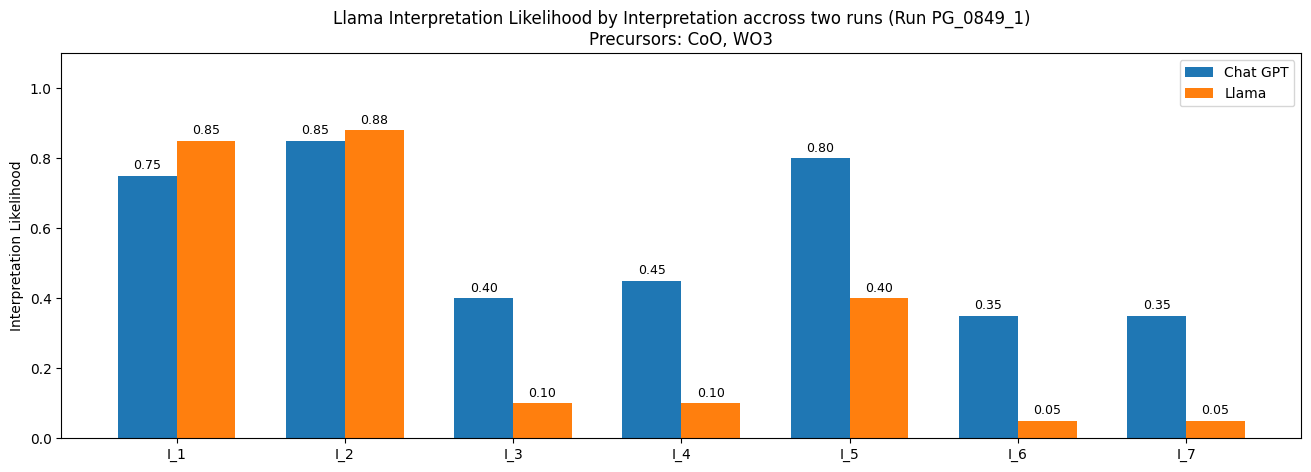

In [ ]:

json_file_path1 = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file_path2 = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file1 = load_json(json_file_path1) 
json_file2 = load_json(json_file_path2)
run = "PG_0849_1"
Interpretation = []
gpt = []
llama = []
for interpret in json_file1[run]:
    if interpret not in ["Synth_Conditions"]:
        gpt_val = json_file1[run][interpret].get("LLM_interpretation_likelihood")
        gpt_exp = json_file1[run][interpret].get("LLM_interpretation_explanation")
        llama_val = json_file2[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama_exp = json_file2[run][interpret].get("LLM_interpretation_explanation_llama")
        #print out the scores and explanations for each interpretation
        print(f"{interpret}: Chat GPT: {gpt_val} - {gpt_exp}")
        print(f"{interpret}: llama: {llama_val} - {llama_exp}") 
        

        if llama_val is not None and gpt_val is not None:
            try:
                gpt.append(float(gpt_val))
                llama.append(float(llama_val))
                Interpretation.append(interpret)
            except ValueError:
                print(f"Non-numeric value in run {run}, interpretation {interpret}: {gpt_val}, {llama_val}")
synth = json_file1[run]["Synth_Conditions"]
if "Precursor 3" in synth:
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'
else:
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}'


x1 = np.arange(len(Interpretation))
width = 0.35

plt.figure(figsize=(16,5))
plt.bar(x1 - width/2, gpt, width, label='Chat GPT')
plt.bar(x1 + width/2, llama, width, label='Llama')
plt.ylabel('Interpretation Likelihood')
plt.title(f'Llama Interpretation Likelihood by Interpretation accross two runs (Run {run})\nPrecursors: {input_phases}')
plt.xticks(x1,Interpretation, rotation=0, ha='center')
for j, val in enumerate(gpt):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout
plt.show()

CoWO4 (13)
Chat GPT: "As in previous interpretations, CoWO4 in P2/c (SG 13) is expected to form under the synthesis conditions."
Llama: "CoWO₄ (SG 13) as a single product seems unlikely given the precursors and conditions. Some unreacted WO₃ or CoO is expected."

Chat GPT Interpretation: "This interpretation is plausible, with CoWO4 in its correct structure. However, the absence of WO3 suggests a complete reaction, which may not be entirely realistic given the synthesis conditions."
Llama Interpretation: "This interpretation is questionable due to the omission of likely unreacted precursors like WO₃."


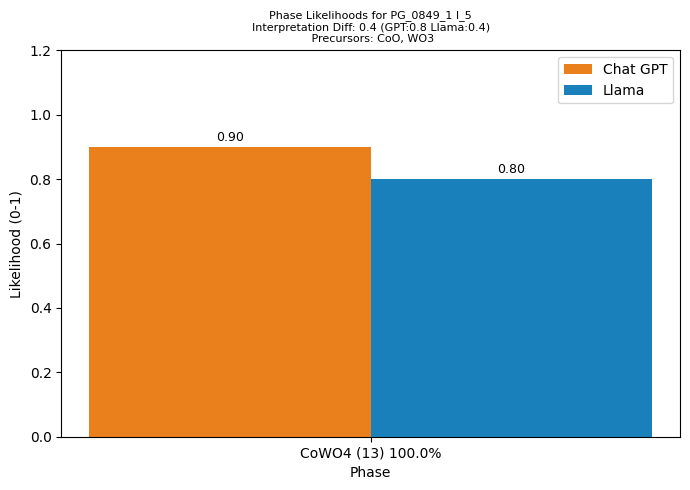

In [ ]:
run = "PG_0849_1"
interpret = "I_5"
json_file_path1 = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file_path2 = "Data/prompt2/interpretations_llm_v5.1_llama2.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
llama_interpret = json_file1[run][interpret]["LLM_interpretation_likelihood_llama"]
gpt_interpret = json_file2[run][interpret]["LLM_interpretation_likelihood"]
diff = round(gpt_interpret - llama_interpret,2)
labels = []
run_interpret1 = json_file1[run][interpret]
run_interpret2 = json_file2[run][interpret]
gpt_phase_likelihood = run_interpret1["LLM_phases_likelihood"]
llama_phase_likelihood = run_interpret2["LLM_phases_likelihood_llama"]
labels_only = list(llama_phase_likelihood.keys())
for i in range(len(labels_only)):
    wf = run_interpret1["weight_fraction"]
    labels.append(f"{phase_key_to_short(labels_only[i])} {round(wf[i],2)}%")

gpt_likelihoods = list(gpt_phase_likelihood.values())
llama_likelihoods = list(llama_phase_likelihood.values())
synth = json_file1[run]["Synth_Conditions"]
if "Precursor 3" in synth:
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'
else:
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}'

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(7,5))

plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "#ea801c")
plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "#1a80bb")

plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
plt.ylabel('Likelihood (0-1)')
plt.xlabel('Phase')
labels = [phase_key_to_short(label) for label in labels]
plt.xticks(x, labels, rotation=0, ha='center')
plt.ylim(0, 1.2)

for j, val in enumerate(gpt_likelihoods):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama_likelihoods):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.legend()
plt.tight_layout()

phase_exp1 = run_interpret1["LLM_phases_explanation"]
phase_exp2 = run_interpret2["LLM_phases_explanation_llama"]
for label in labels_only:
    print(phase_key_to_short(label))
    print(f'Chat GPT: "{phase_exp1[label]}"')
    print(f'Llama: "{phase_exp2[label]}"')
print("")
print(f'Chat GPT Interpretation: "{run_interpret1["LLM_interpretation_explanation"]}"')
print(f'Llama Interpretation: "{run_interpret1["LLM_interpretation_explanation_llama"]}"')
    
plt.show()



In [ ]:
json_file_path = "Data/prompt1/interpretations_llm_v1_llama1.json"
json_file = load_json(json_file_path)
large_diff_all = []
for sample in json_file:
    large_diff = 0
    if not any(key.startswith("I_") for key in json_file[sample]):
        continue
    for interpret in json_file[sample]:
        if interpret not in ["Synth_Conditions"]:
            gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
            llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
            score_diff = gpt_score - llama_score
            if abs(score_diff) > 0.1005:
                large_diff += 1
    sample_tot = (sample,large_diff)
    large_diff_all.append(sample_tot)

sorted_list = sorted(large_diff_all, key=lambda x: x[1])
print(sorted_list)

[('TRI_28', 0), ('TRI_30', 1), ('TRI_197', 1), ('TRI_84', 1), ('TRI_126', 2), ('TRI_63', 2), ('TRI_182', 2), ('TRI_104', 3), ('TRI_39', 3), ('TRI_172', 3), ('TRI_106', 3), ('TRI_31', 5), ('TRI_112', 7), ('TRI_181', 28)]


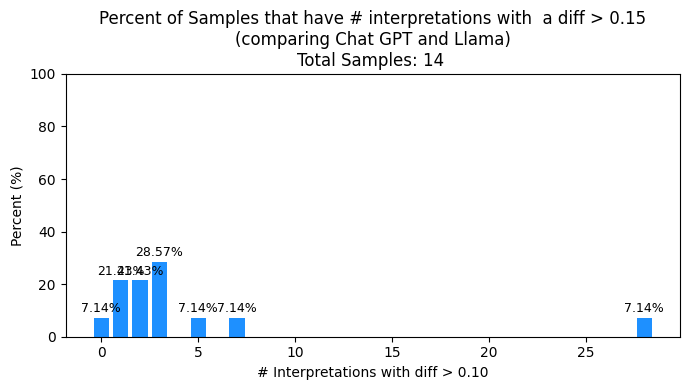

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_tuple_bar_graph(tuple_list, xlabel="# Interpretations with diff > 0.10", ylabel="Percent (%)"):
    values = [t[1] for t in tuple_list]
    counts = Counter(values)
    num_interpretations = 0
    for sample in json_file:
        for interpret in json_file[sample]:
            if interpret not in ["Synth_Conditions"]:
                num_interpretations += 1
    try:
        categories, raw_frequencies = zip(*sorted(counts.items(), key=lambda x: float(x[0])))
    except:
        categories, raw_frequencies = zip(*counts.items())
    
    total = sum(raw_frequencies)
    frequencies = [(i / total) * 100 for i in raw_frequencies]
    
    title = f"Percent of Samples that have # interpretations with  a diff > 0.15\n(comparing Chat GPT and Llama)\nTotal Samples: {total} "
    
    plt.figure(figsize=(7, 4))
    bars = plt.bar(categories, frequencies, color='dodgerblue')
    
    for bar, val in zip(bars, frequencies):
        height = bar.get_height()
        offset = 1 if val > 5 else 0.3
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + offset,
            f"{val:.2f}%",
            ha='center', va='bottom', fontsize=9
        )
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

plot_tuple_bar_graph(sorted_list)


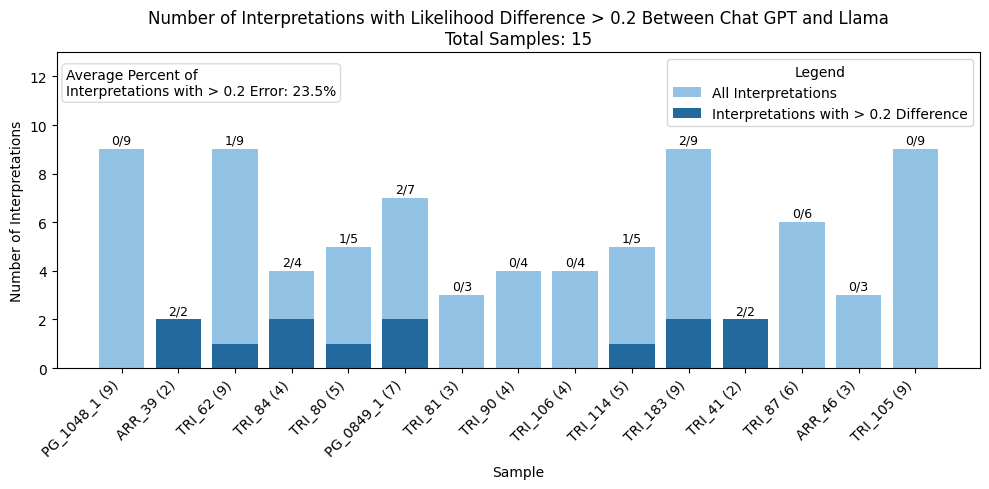

In [ ]:
import matplotlib.pyplot as plt

json_file_path = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
json_file = load_json(json_file_path)
def plot_all_largeDiff(json_file):
    large_diff_all = []

    num = 0.2

    for sample in json_file:
        #print("hello")
        large_diff = 0
        for interpret in json_file[sample]:
            if interpret not in ["Synth_Conditions"]:
                phases = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                weightfractions = json_file[sample][interpret]["weight_fraction"]
                #if len(phases) == len(weightfractions):
                gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                score_diff = gpt_score - llama_score
                if abs(score_diff) > num +0.005:
                    large_diff += 1
        sample_tot = (sample,large_diff)
        large_diff_all.append(sample_tot)

    sorted_list = sorted(large_diff_all, key=lambda x: x[1])

    #print(sorted_list)
    def plot_named_bar_graph(data, xlabel="Sample", ylabel="Number of Interpretations"):
        """
        Plots a bar graph where each bar is labeled by the first element of each tuple,
        and the height is the second element.
        """
        labels = [item[0] for item in data]
        values = [item[1] for item in data]
        num_dict = {}
        #print(labels)
        for sample in labels:
            num_interpretations = 0
            if sample in json_file:
                for interpret in json_file[sample]:
                    if interpret not in ["Synth_Conditions"]:
                        phases = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                        weightfractions = json_file[sample][interpret]["weight_fraction"]
                        #if len(phases) == len(weightfractions):
                        num_interpretations += 1
            num_dict[sample] = num_interpretations
        #print(num_dict)
        labels = [f"{label} ({num_dict[label]})" for label in labels]
        plt.figure(figsize=(10, 5))
        second_bar = list(num_dict.values())
        plt.bar(labels, second_bar, color="#92c3e4", label = "All Interpretations")
        bars = plt.bar(labels, values, color="#226a9e", label = f"Interpretations with > {num} Difference")
        
        title= f"Number of Interpretations with Likelihood Difference > {num} Between Chat GPT and Llama\nTotal Samples: {len(labels)}"
        # Add value labels on top of each bar
        percentage_high_error = []
        for bar, value, tot in zip(bars, values,second_bar):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                tot + 0.1,
                f"{value}/{tot}",
                ha='center',
                va='bottom',
                fontsize=9
            )
            percentage_high_error.append(value/tot*100)
        average = round(np.average(percentage_high_error),2)
        # Add text box in top-left corner
        plt.text(0.01, 0.95, f'Average Percent of\nInterpretations with > {num} Error: {average:.1f}%', transform=plt.gca().transAxes,
            ha='left', va='top', fontsize=plt.rcParams['legend.fontsize'],
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='lightgrey', alpha=0.8))

        y_limit = max(second_bar)
        plt.ylim(0, y_limit + 4)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title="Legend")
        plt.tight_layout()
        plt.show()

    plot_named_bar_graph(large_diff_all)